In [1]:
%load_ext autoreload
%autoreload 2
import extract_environment as ee
import time
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import os
import xarray as xr
import dask
from dask.distributed import Client


In [2]:
dir_env = '/home/kbrennan/phd/data/climate/present'
dir_track = '/home/kbrennan/phd/data/climate/tracks/present'
day = '20210628'

now = pd.to_datetime(day+'18', format='%Y%m%d%H')

In [3]:
cells = ee.load_cells(dir_track, day)

In [4]:
cell = cells[83]

In [5]:
cell.keys()

dict_keys(['cell_id', 'parent', 'child', 'merged_to', 'died_of', 'lifespan', 'datelist', 'lon', 'lat', 'mass_center_x', 'mass_center_y', 'max_x', 'max_y', 'delta_x', 'delta_y', 'area_gp', 'max_val', 'score'])

In [6]:
env = ee.load_environments(dir_env, now)

In [7]:
cookie = ee.cutout_cookie(cell, env, now)
cookie

<xarray.Dataset>
Dimensions:       (time: 1, x: 51, y: 51, pressure: 8)
Coordinates:
  * time          (time) datetime64[ns] 2021-06-28T18:00:00
  * x             (x) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * y             (y) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * pressure      (pressure) float32 2e+04 3e+04 4e+04 ... 8.5e+04 9.25e+04
Data variables: (12/61)
    rotated_pole  |S1 ...
    wbtemp_13c    float32 ...
    U_10M         (time, y, x) float32 ...
    V_10M         (time, y, x) float32 ...
    VMAX_10M      (time, y, x) float32 ...
    T_2M          (time, y, x) float32 ...
    ...            ...
    U             (time, pressure, y, x) float32 dask.array<chunksize=(1, 8, 51, 51), meta=np.ndarray>
    V             (time, pressure, y, x) float32 dask.array<chunksize=(1, 8, 51, 51), meta=np.ndarray>
    W             (time, pressure, y, x) float32 dask.array<chunksize=(1, 8, 51, 51), meta=np.ndarray>
    TOT_PREC      (time, y, x) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    TOT_SNOW      (time, y, x) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    DHAIL_MX      (time, y, x) float32 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
Attributes:
    title:           COSMO driven by ERA5
    source:          COSMO_5.08
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    creation_date:   2023-09-29 12:35:28

In [8]:
dir_cookie = "/home/kbrennan/phd/data/climate/cookies/present/cookie_202106010001100.nc"
cookie = xr.open_dataset(dir_cookie)

In [9]:
cookie

<xarray.Dataset>
Dimensions:        (cookie_id: 1, x: 51, y: 51, pressure: 8)
Coordinates:
  * cookie_id      (cookie_id) int64 202106010001100
  * pressure       (pressure) float32 2e+04 3e+04 4e+04 ... 8.5e+04 9.25e+04
  * x              (x) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * y              (y) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
Data variables: (12/70)
    rotated_pole   (cookie_id, x, y) |S1 ...
    wbtemp_13c     (cookie_id, x, y) float64 ...
    U_10M          (cookie_id, x, y) float64 ...
    V_10M          (cookie_id, x, y) float64 ...
    VMAX_10M       (cookie_id, x, y) float64 ...
    T_2M           (cookie_id, x, y) float64 ...
    ...             ...
    max_val        (cookie_id) float64 ...
    real_time      (cookie_id) datetime64[ns] ...
    t_rel_start    (cookie_id) float64 ...
    t_rel_end      (cookie_id) float64 ...
    t_rel_max      (cookie_id) float64 ...
    itime          (cookie_id) int64 ...
Attributes:
    title:           COSMO driven by ERA5
    source:          COSMO_5.08
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    creation_date:   2023-09-28 17:50:42

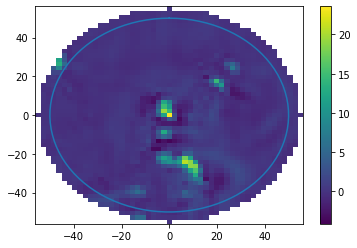

In [10]:
plt.pcolormesh(cookie.x,cookie.y,cookie.W.sel(pressure=40000).squeeze())
# plot circle
circle = plt.plot(np.sin(np.linspace(0,2*np.pi,100))*50,np.cos(np.linspace(0,2*np.pi,100))*50)
plt.colorbar()

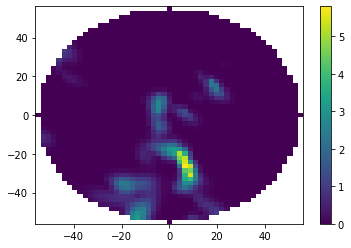

In [11]:
plt.pcolormesh(cookie.x,cookie.y,cookie.TOT_PREC.squeeze())
plt.colorbar()

In [12]:
inpath = "/home/kbrennan/phd/data/climate/cookies/present"

# load data
dset = xr.open_mfdataset(inpath + "/*.nc", combine="by_coords", parallel=True)

In [28]:
dset

<xarray.Dataset>
Dimensions:        (cookie_id: 46, x: 51, y: 51, pressure: 8)
Coordinates:
  * cookie_id      (cookie_id) int64 202106010001100 ... 202106050000700
  * pressure       (pressure) float32 2e+04 3e+04 4e+04 ... 8.5e+04 9.25e+04
  * x              (x) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * y              (y) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
Data variables: (12/70)
    rotated_pole   (cookie_id, x, y) |S1 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    wbtemp_13c     (cookie_id, x, y) float64 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    U_10M          (cookie_id, x, y) float64 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    V_10M          (cookie_id, x, y) float64 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    VMAX_10M       (cookie_id, x, y) float64 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    T_2M           (cookie_id, x, y) float64 dask.array<chunksize=(1, 51, 51), meta=np.ndarray>
    ...             ...
    max_val        (cookie_id) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    real_time      (cookie_id) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    t_rel_start    (cookie_id) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    t_rel_end      (cookie_id) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    t_rel_max      (cookie_id) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    itime          (cookie_id) int64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    title:           COSMO driven by ERA5
    source:          COSMO_5.08
    Conventions:     CF-1.4
    conventionsURL:  http://www.cfconventions.org/
    creation_date:   2023-09-28 17:50:42

In [14]:
# compute stats in palallel
# mean over cell_id
mean = dset.mean(dim="cookie_id", skipna=True)
# 90th percentile over cell_id
# p90 = dset.weighted(dset.n_timesteps).quantile(0.9, dim="cell_id", skipna=True)
# standard deviation over cell_id
std = dset.std(dim="cookie_id", skipna=True)

/home/kbrennan/.conda/envs/kbrennan_2022/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/kbrennan/.conda/envs/kbrennan_2022/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/kbrennan/.conda/envs/kbrennan_2022/lib/python3.9/site-packages/numpy/core/_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [15]:
mean

<xarray.Dataset>
Dimensions:        (x: 51, y: 51, pressure: 8)
Coordinates:
  * pressure       (pressure) float32 2e+04 3e+04 4e+04 ... 8.5e+04 9.25e+04
  * x              (x) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
  * y              (y) float64 -55.0 -52.8 -50.6 -48.4 ... 48.4 50.6 52.8 55.0
Data variables: (12/68)
    wbtemp_13c     (x, y) float64 dask.array<chunksize=(51, 51), meta=np.ndarray>
    U_10M          (x, y) float64 dask.array<chunksize=(51, 51), meta=np.ndarray>
    V_10M          (x, y) float64 dask.array<chunksize=(51, 51), meta=np.ndarray>
    VMAX_10M       (x, y) float64 dask.array<chunksize=(51, 51), meta=np.ndarray>
    T_2M           (x, y) float64 dask.array<chunksize=(51, 51), meta=np.ndarray>
    TD_2M          (x, y) float64 dask.array<chunksize=(51, 51), meta=np.ndarray>
    ...             ...
    cell_lifespan  float64 dask.array<chunksize=(), meta=np.ndarray>
    max_val        float64 dask.array<chunksize=(), meta=np.ndarray>
    t_rel_start    float64 dask.array<chunksize=(), meta=np.ndarray>
    t_rel_end      float64 dask.array<chunksize=(), meta=np.ndarray>
    t_rel_max      float64 dask.array<chunksize=(), meta=np.ndarray>
    itime          float64 dask.array<chunksize=(), meta=np.ndarray>

In [16]:
# mean = mean.compute()

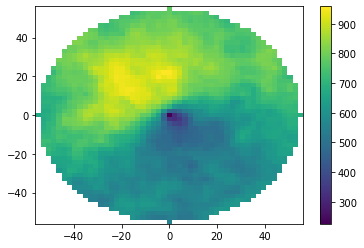

In [17]:
plt.pcolormesh(mean.x,mean.y,mean.CAPE_MU)
plt.colorbar()

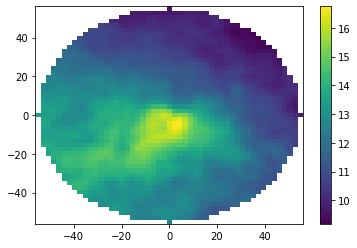

In [18]:
plt.pcolormesh(mean.x,mean.y,mean.VMAX_10M)
plt.colorbar()

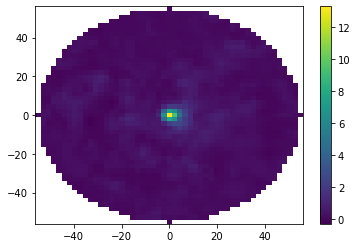

In [19]:
plt.pcolormesh(mean.x,mean.y,mean.W.sel(pressure=40000))
plt.colorbar()